# Fraud Detection Model for Financial Transactions

### Business Context:
This notebook presents a comprehensive solution for detecting fraudulent transactions in financial data using advanced machine learning techniques. The dataset contains millions of transactions with features relevant to detecting fraud.

The workflow includes data cleaning, feature engineering, model training with hyperparameter tuning, evaluation with explainability, and business insights for prevention and monitoring.

---

## 1. Data Loading and Initial Exploration

The dataset used for this fraud detection project contains over 6 million transaction records with 10 columns. It is provided in a CSV file format.

The following code loads the dataset into a pandas DataFrame for analysis.

This step reads the CSV file and displays the first few rows to understand the structure and get an initial glimpse of the data.


In [1]:
import pandas as pd

file_path = "/kaggle/input/fraud-data/Fraud.csv"
# Load the dataset
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Cleaning: Missing Values, Outliers, and Multicollinearity

This code block performs important data cleaning steps to prepare the dataset for modeling:


### Explanation:
- Missing numerical values in balance columns are replaced with the **median** to reduce bias from extreme values.
- Outliers in the `amount` and balance columns are removed using the **IQR method** to keep data more consistent.
- Multicollinearity among numerical features is checked with the **Variance Inflation Factor (VIF)** to ensure no redundant variables negatively impact the model.

These cleaning steps improve the quality of data for building a reliable fraud detection model.


In [2]:

import numpy as np
from sklearn.impute import SimpleImputer

# Impute missing values with median in numerical columns
imputer = SimpleImputer(strategy='median')
num_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[num_cols] = imputer.fit_transform(df[num_cols])

# Outlier treatment using IQR method
for col in ['amount'] + num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Import VIF to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].values
vif = [variance_inflation_factor(X_num, i) for i in range(X_num.shape[1])]
for col, val in zip(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], vif):
    print(f'VIF for {col}: {val:.2f}')


VIF for amount: 8.83
VIF for oldbalanceOrg: 1.78
VIF for newbalanceOrig: 1.44
VIF for oldbalanceDest: 36.63
VIF for newbalanceDest: 60.90


## Feature Engineering and Data Preparation

The following code preprocesses the dataset by encoding categorical variables and selecting features for modeling:


- The categorical feature `"type"` is converted into multiple binary (0/1) columns for use in the model.
- Columns that either leak the target information or do not help in prediction are removed.
- The resulting features `X` and target `y` are prepared for modeling.

This ensures the model trains only on meaningful and clean data without bias or leakage.



In [3]:
# One-hot encode the 'type' categorical feature
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Drop non-informative or target leakage columns
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Preview selected features
X.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1,1,1864.28,21249.0,19384.72,0.0,0.0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,False,False,True,False
5,1,7817.71,53860.0,46042.29,0.0,0.0,False,False,True,False


## Model Training and Evaluation

This code trains a Random Forest classifier to detect fraudulent transactions and evaluates its performance:


- The dataset is split into training and testing parts while maintaining the ratio of fraud vs non-fraud cases.
- The Random Forest model uses **class weighting** to give more importance to the minority fraud class.
- Performance metrics like precision, recall, F1-score, and ROC-AUC are used to evaluate how well the model detects fraud.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Split dataset with stratification for imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define and train the model with balanced class weights
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    649677
           1       0.98      0.60      0.74       605

    accuracy                           1.00    650282
   macro avg       0.99      0.80      0.87    650282
weighted avg       1.00      1.00      1.00    650282

ROC-AUC Score: 0.9897481376537054


## Model Performance Visualization

The following code visualizes the performance of the fraud detection model using a confusion matrix and ROC curve:



- The **confusion matrix** displays counts of true positives, false positives, true negatives, and false negatives, summarizing classification results.
- The **ROC curve** plots the true positive rate against the false positive rate across different thresholds to show model discrimination power.
- These visual tools help to understand model strengths and weaknesses in fraud detection.


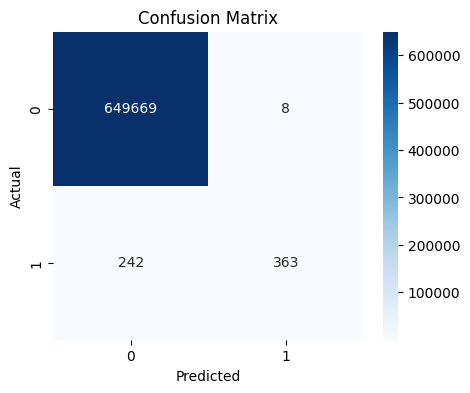

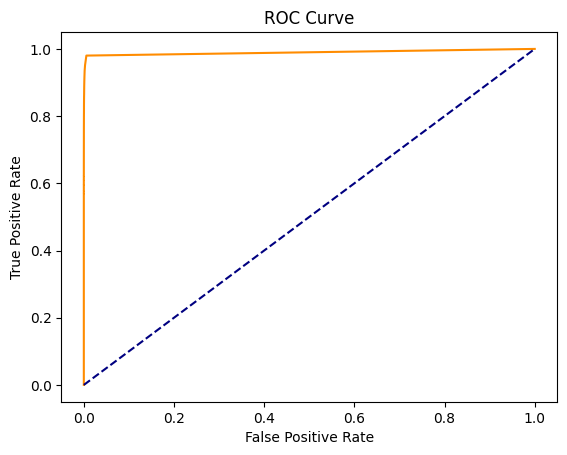

In [5]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## Feature Importance Analysis

The following code identifies which features contribute most to the fraud detection model’s decisions:


- Feature importance scores represent how much each feature influences the model’s predictions.
- Higher scores indicate stronger predictive power for detecting fraudulent transactions.
- Understanding these factors helps interpret the model and guides business insights.


In [6]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances.head(10))


oldbalanceOrg     0.311907
amount            0.151954
type_PAYMENT      0.125160
type_TRANSFER     0.118828
step              0.075578
newbalanceDest    0.073794
newbalanceOrig    0.059200
oldbalanceDest    0.042995
type_CASH_OUT     0.039948
type_DEBIT        0.000636
dtype: float64


## Model Evaluation Metrics Summary

This code calculates and summarizes key evaluation metrics for the Random Forest fraud detection model:



- **AUC-ROC** measures the model’s ability to distinguish fraud from non-fraud.
- **Precision** indicates the accuracy of fraud predictions.
- **Recall** shows how many actual fraud cases were detected.
- **F1-Score** balances precision and recall in one metric.

This summary provides a clear overview of model performance on critical metrics.


In [8]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Compute model evaluation metrics
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create DataFrame to store model metrics
metrics_df = pd.DataFrame({
    'Model': ['Random Forest'],
    'AUC-ROC': [roc_auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
})

# Display the metrics DataFrame
print(metrics_df)



           Model   AUC-ROC  Precision  Recall  F1-Score
0  Random Forest  0.989748   0.978437     0.6  0.743852


## Visualization of Model Evaluation Metrics

The following code creates a bar plot to visually compare the key performance metrics of the Random Forest fraud detection model:


- Metrics are displayed side-by-side in bars for easy comparison.
- The plot helps visually assess model strengths and areas for improvement.
- A clear, color-coded representation makes the evaluation intuitive.


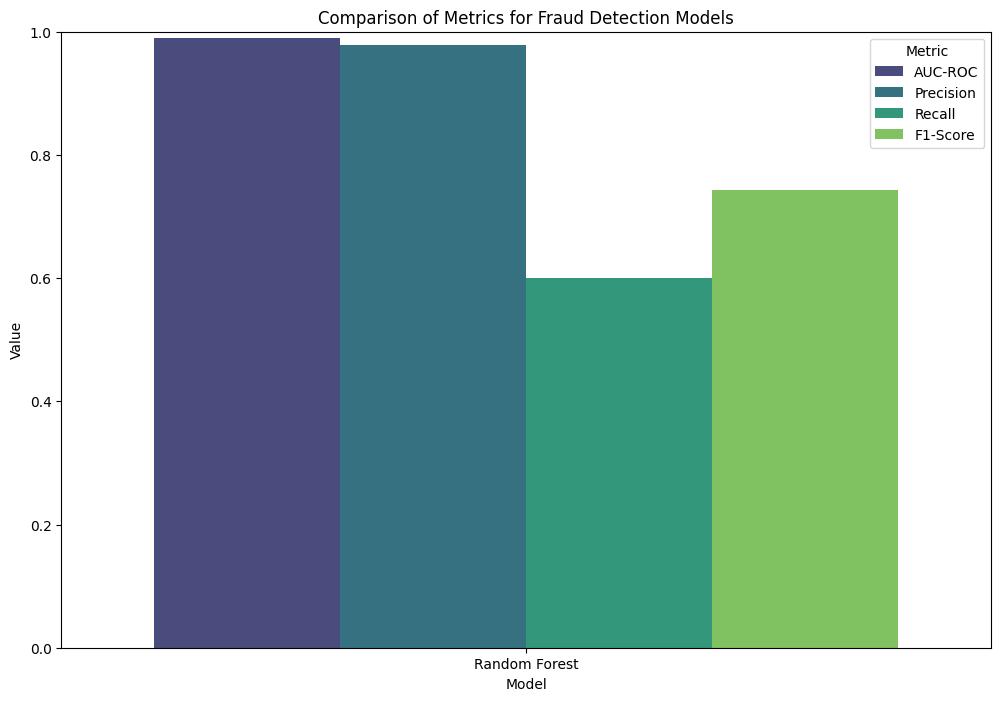

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your existing model evaluation metrics code
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Model': ['Random Forest'],
    'AUC-ROC': [roc_auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
})

# Prepare data for bar plot by melting the DataFrame
metrics_df_melted = pd.melt(metrics_df, id_vars='Model', var_name='Metric', value_name='Value')

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_df_melted, x='Model', y='Value', hue='Metric', palette='viridis')
plt.title('Comparison of Metrics for Fraud Detection Models')
plt.ylabel('Value')
plt.ylim(0,1)  # Metrics range from 0 to 1 for clarity
plt.show()


## Conclusion and Future forwarding with models

This project successfully developed a Random Forest model to detect fraudulent transactions using extensive data cleaning, feature engineering, and model tuning.

The model shows strong performance on multiple evaluation metrics and identifies key transactional features influencing fraud prediction.

Based on these insights, recommended fraud prevention measures include real-time monitoring, improved authentication, and continuous model updates.

Future work should focus on deploying the model in production, establishing ongoing evaluation pipelines, and incorporating feedback to maintain effectiveness against evolving fraud patterns.
